In [12]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score

from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

In [13]:
files_count = [1]
tries_count = 1
sample_size = 0.1

In [14]:
def get_raw_data(files_count, tries_count):
    list_raw_data = []
    for file_count in files_count:
        for raw_data in range(tries_count):
            file_indexes = np.random.choice(
                range(1, 1289),
                file_count,
                replace=False
            ).tolist()

            dfs = list()
            for index in file_indexes:
                try:
                    target_path = 'mdl_logstore_standard_log/mdl_logstore_standard_log_202304141914_{}.csv'.format(index)
                    data = pd.read_csv(target_path, sep=';')
                    data['fileindex'] = index
                    dfs.append(data)
                except Exception as e:
                    print('Unable to read target_path on index {}'.format(index))
                    print(e)
            df = pd.concat(dfs, ignore_index=True)
            list_raw_data.append(df)
        
    return list_raw_data

In [15]:
raw_lst = get_raw_data(files_count, tries_count)

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [17]:
def preprocess_raw_data(df):
    df = df.drop(columns=['id', 'realuserid', 'other', 'objecttable', 'component', 'action', 'target', 'anonymous'])
    
    df['objectid'].fillna(-1.0, inplace=True)
    df['relateduserid'].fillna(-1.0, inplace=True)
    df['origin'].fillna('unknown', inplace=True)
    df['ip'].fillna('unknown', inplace=True)
    
    numerical = pd.DataFrame(df['timecreated'])
    categorical = df.drop('timecreated', axis=1)
    
    numerical['timecreated'] = MinMaxScaler().fit_transform(numerical['timecreated'].to_numpy().reshape(-1, 1))
    ohe = OneHotEncoder(min_frequency=0.01, sparse_output=False)
    categorical = pd.DataFrame(ohe.fit_transform(categorical))
    categorical.columns = ohe.get_feature_names_out()
    df2 = pd.concat([categorical, numerical], axis=1)
    assert not df.isnull().values.any()
    return df2

In [18]:
preprocessed_lst = [preprocess_raw_data(df) for df in raw_lst]

In [19]:
def get_models(n_clusters=8):
    models = [
          KMeans(n_clusters=n_clusters, random_state=1),
          Birch(n_clusters=n_clusters),
          AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
          AgglomerativeClustering(n_clusters=n_clusters, linkage='single'),
          AgglomerativeClustering(n_clusters=n_clusters, linkage='average'),
          AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
         ]
    model_names = ['Kmeans_{}'.format(n_clusters),
                   'Birch_{}'.format(n_clusters),
                   'HWard_{}'.format(n_clusters),
                   'HSingle_{}'.format(n_clusters),
                   'HAverage_{}'.format(n_clusters),
                   'HComplete_{}'.format(n_clusters)
                  ]
    
    return models, model_names

In [20]:
def collect_metrics(df, models, model_names):
    labels = dict()
    silhouette_scores = dict()
    davies_bouldin_scores = dict()
    calinski_harabasz_scores = dict()
    data = df.sample(frac=0.1, random_state=1)
    for idx, model in enumerate(models):
        labels[model_names[idx]] = model.fit(data).labels_
        silhouette_scores[model_names[idx]] = metrics.silhouette_score(data, labels[model_names[idx]], metric='euclidean')
        davies_bouldin_scores[model_names[idx]] = metrics.davies_bouldin_score(data, labels[model_names[idx]])
        calinski_harabasz_scores[model_names[idx]] = metrics.calinski_harabasz_score(data, labels[model_names[idx]])
    return labels, silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores

In [23]:
def get_results(files_count, tries_count, n_clusters=8, sample_size=0.1, ):
    raw_lst = get_raw_data(files_count, tries_count)
    preprocessed_lst = [preprocess_raw_data(df) for df in raw_lst]
    labels_lst = []
    silhouette_score_lst = []
    davies_bouldin_score_lst = []
    calinski_harabasz_score_lst = []
    for df in preprocessed_lst:
        models, model_names = get_models(n_clusters)
        labels, silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores = collect_metrics(df, models, model_names)
        labels_lst.append(labels)
        silhouette_score_lst.append(silhouette_scores)
        davies_bouldin_score_lst.append(davies_bouldin_scores)
        calinski_harabasz_score_lst.append(calinski_harabasz_scores)
    return labels_lst, silhouette_score_lst, davies_bouldin_score_lst, calinski_harabasz_score_lst

In [24]:
labels_lst, silhouette_score_lst, davies_bouldin_score_lst, calinski_harabasz_score_lst = get_results(files_count=[1], tries_count=1)

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [25]:
def filter_metric(filtered, files_count, model_names, results):
    for cnt, file in enumerate(files_count):
        for model in model_names:
            name = model[:model.rfind("_")] + '_fs{}'.format(file)
            res = results[cnt][model]
            if name not in filtered.keys():
                filtered[name] = list()
            filtered[name].append(res)
    return filtered

In [26]:
def get_scores_sequences(files_count, tries_count, sample_size=0.1, n_clusters=[8]):
    f_silhouette, f_davies, f_calinski = {}, {}, {}
    for n in n_clusters:
        models, model_names = get_models(n)
        labels_lst, silhouette_score_lst, davies_bouldin_score_lst, calinski_harabasz_score_lst = get_results(files_count=files_count, tries_count=tries_count, n_clusters=n)
        f_silhouette = filter_metric(f_silhouette, files_count, model_names, silhouette_score_lst)
        f_davies = filter_metric(f_davies, files_count, model_names, davies_bouldin_score_lst)
        f_calinski = filter_metric(f_calinski, files_count, model_names, calinski_harabasz_score_lst)
    return f_silhouette, f_davies, f_calinski

In [32]:
import matplotlib.pyplot as plt

In [43]:
def plot_metric_by_clusters(metric, metric_name, n_clusters, print_max=True):
    fig=plt.figure()
    fig.show()
    ax=fig.add_subplot(111)
    for key in metric.keys():
        if print_max:
            print(metric_name + str(max(metric[key])))
        ax.plot(n_clusters, metric[key], label=key)
    
    plt.xlabel('Number of Clusters')
    plt.ylabel('{} Score'.format(metric_name))
    plt.title('{} Score vs Number of Clusters'.format(metric_name))
    plt.legend(loc=2)
    plt.draw()

In [29]:
n_clusters = [4, 8, 16, 32]
f_silhouette, f_davies, f_calinski = get_scores_sequences([1], 1, 0.1, n_clusters)

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

C:\Users\aspet\AppData\Local\Temp\ipykernel_20192\1043624171.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


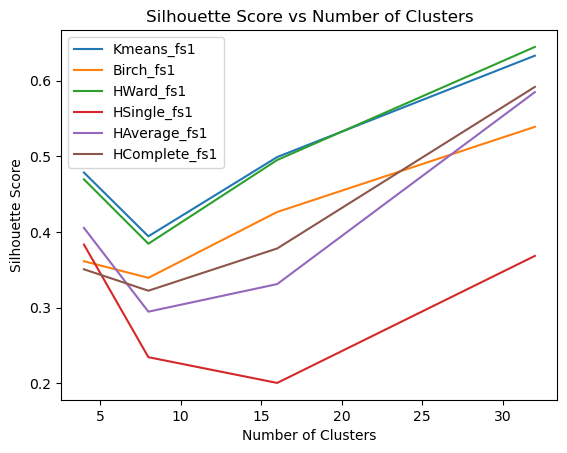

In [36]:
plot_metric_by_clusters(f_silhouette, 'Silhouette', n_clusters=[4, 8, 16, 32])

In [37]:
def plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[4, 8]):
    f_silhouette, f_davies, f_calinski = get_scores_sequences(files_count, tries_count, sample_size, n_clusters)
    plot_metric_by_clusters(f_silhouette, 'Silhouette', n_clusters=n_clusters)
    plot_metric_by_clusters(f_davies, 'Davies-Bouldin', n_clusters=n_clusters)
    plot_metric_by_clusters(f_calinski, 'Calinski-Harabasz', n_clusters=n_clusters)

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

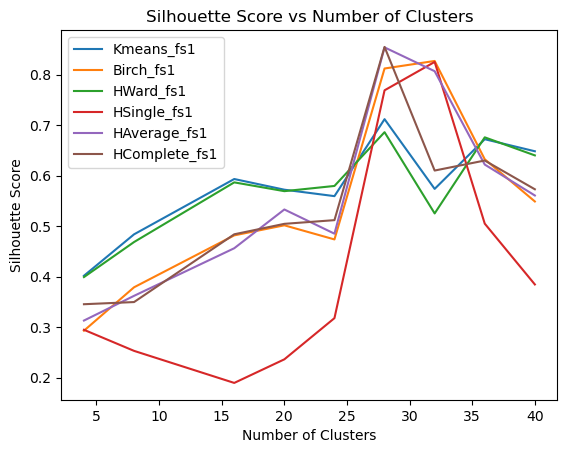

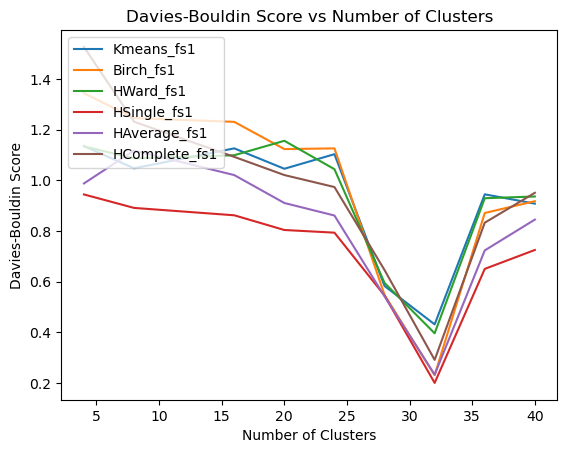

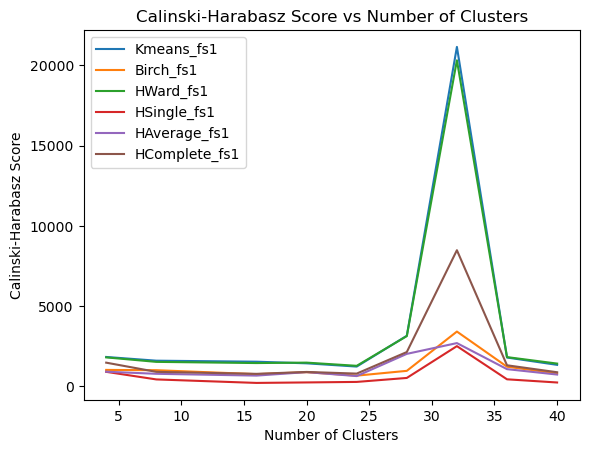

In [39]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[4, 8, 16, 20, 24, 28, 32, 36, 40])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

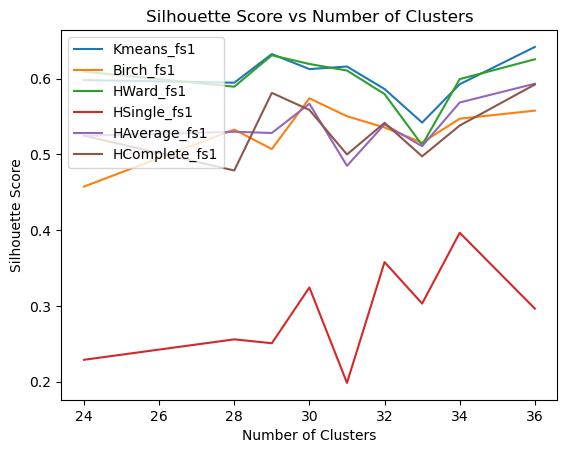

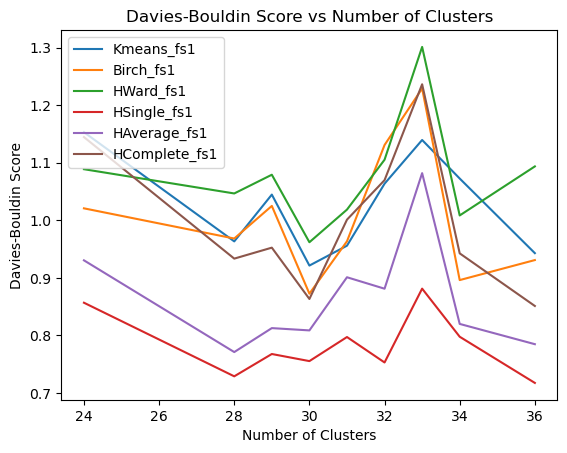

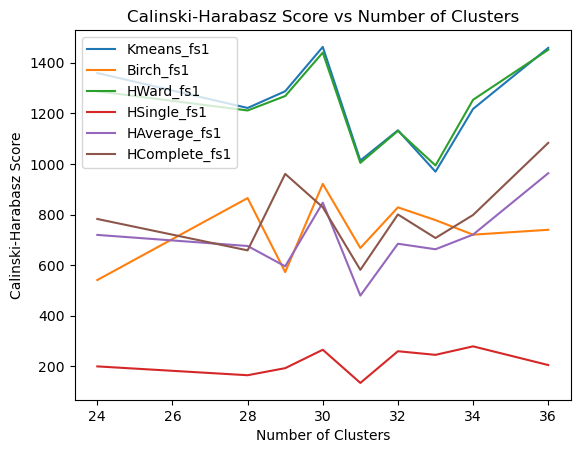

In [40]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[24, 28, 29, 30, 31, 32, 33, 34, 36])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

0.6782672863806106
0.8565869941037446
0.6455887235633003
0.8515653543090637
0.8578854146649375
0.8184026191278874
1.5256310620604754
1.5479784616443717
1.5589908034579354
0.9585343284618633
1.1904492807203786
1.5732224813677707
8028.845207504027
2100.342900663263
7811.326411222301
1944.3206435294383
2119.288519025198
2867.7815416891676


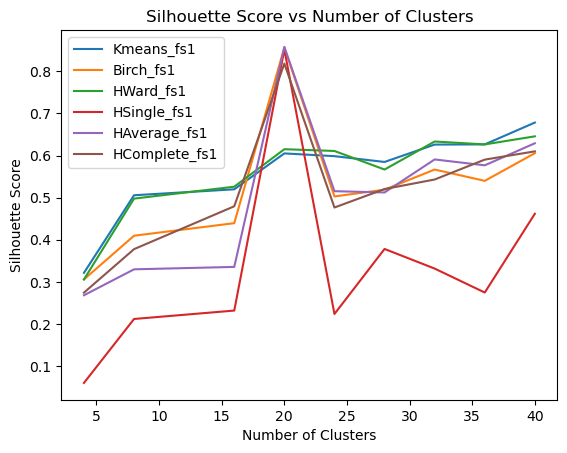

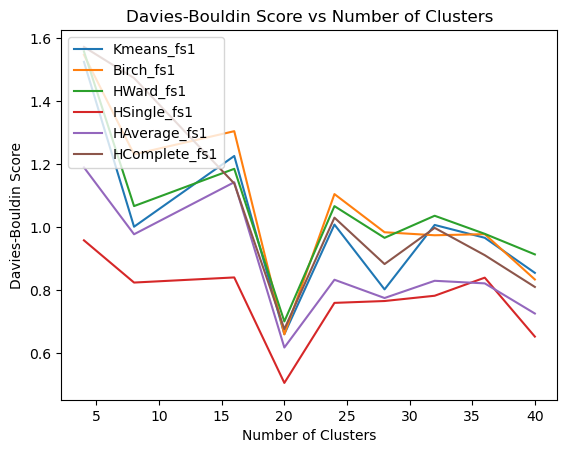

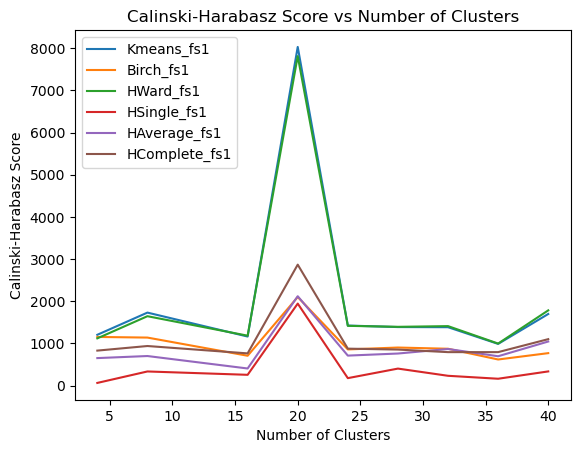

In [42]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[4, 8, 16, 20, 24, 28, 32, 36, 40])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette0.7274251780742499
Silhouette0.6455002030756882
Silhouette0.728207991412609
Silhouette0.5157019297410907
Silhouette0.6583653569888172
Silhouette0.6502672826242808
Davies-Bouldin1.9363702770884588
Davies-Bouldin2.2120240829828473
Davies-Bouldin1.6807009451257877
Davies-Bouldin1.062603454246701
Davies-Bouldin1.7022002755425516
Davies-Bouldin1.8211145011575567
Calinski-Harabasz2373.995375318698
Calinski-Harabasz1178.683892484111
Calinski-Harabasz2349.9254157196906
Calinski-Harabasz520.8658415613992
Calinski-Harabasz1257.2082826127373
Calinski-Harabasz1117.051388833606


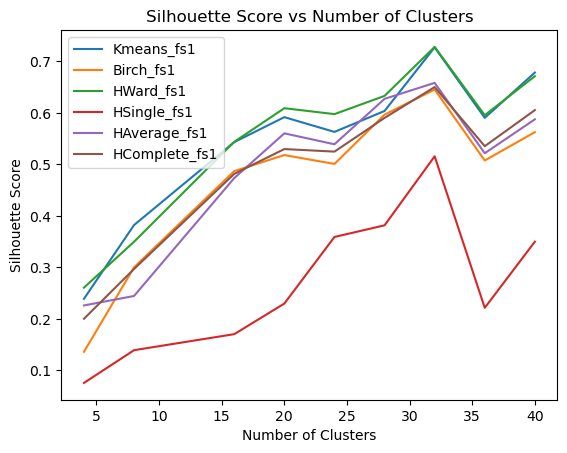

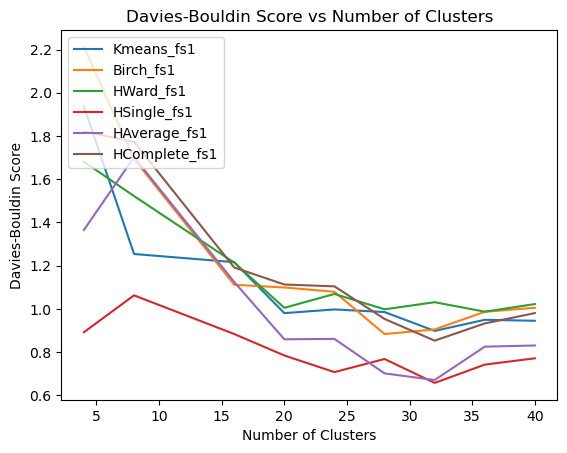

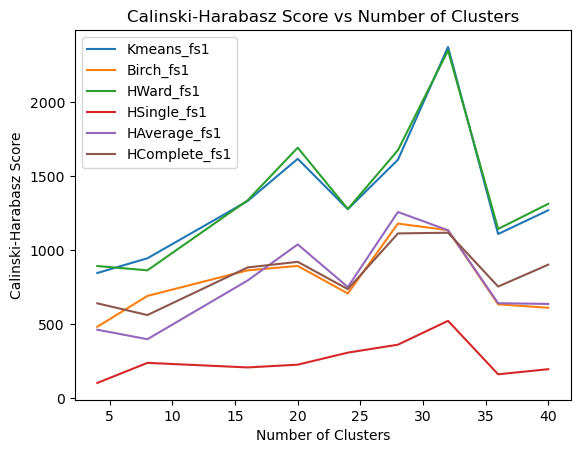

In [44]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[4, 8, 16, 20, 24, 28, 32, 36, 40])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette0.7915546085660435
Silhouette0.8994610440471854
Silhouette0.780411174882353
Silhouette0.9023543611446844
Silhouette0.9083912786693839
Silhouette0.9091137925830641
Davies-Bouldin1.2462001591040557
Davies-Bouldin1.5274080602334248
Davies-Bouldin1.443708573665009
Davies-Bouldin1.039905212437084
Davies-Bouldin1.320975800712765
Davies-Bouldin1.6284658137111243
Calinski-Harabasz17974.26511719783
Calinski-Harabasz5309.386726517119
Calinski-Harabasz17782.845157948574
Calinski-Harabasz5223.876117965208
Calinski-Harabasz6256.134225965059
Calinski-Harabasz6333.216473280044


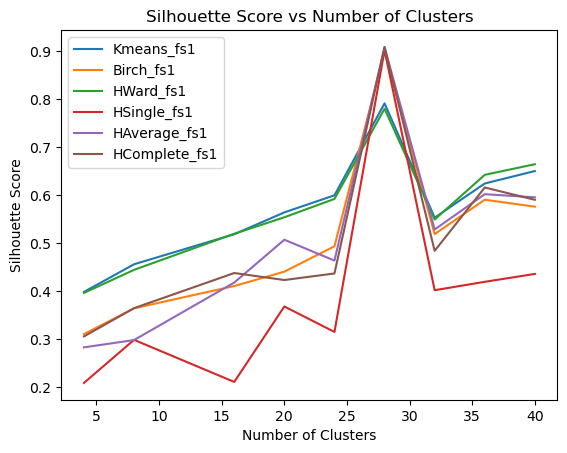

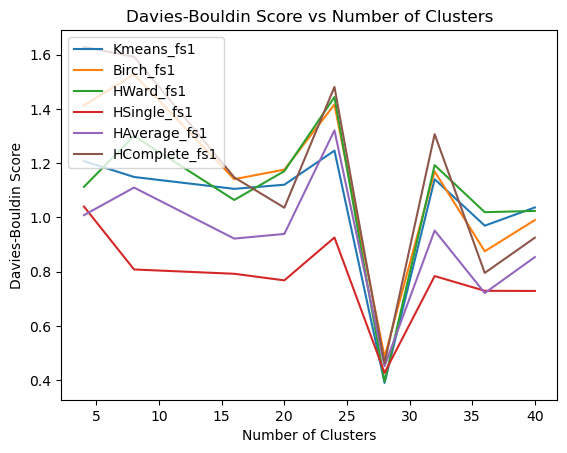

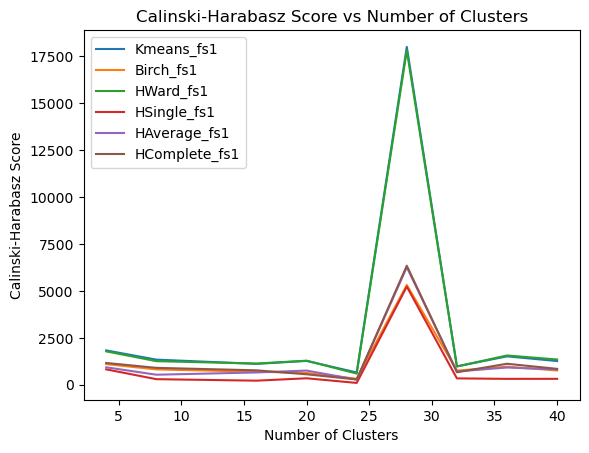

In [45]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[4, 8, 16, 20, 24, 28, 32, 36, 40])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette0.8215894646303814
Silhouette0.6479425104864853
Silhouette0.8280983148571225
Silhouette0.6529009790767403
Silhouette0.684386560391922
Silhouette0.7490973701194062
Davies-Bouldin1.1100789377573295
Davies-Bouldin1.35967022480418
Davies-Bouldin1.2041149379525078
Davies-Bouldin0.8541009088949827
Davies-Bouldin1.060642583001203
Davies-Bouldin1.1592669107464635
Calinski-Harabasz2610.140549790413
Calinski-Harabasz1198.1182346912517
Calinski-Harabasz2576.225369262282
Calinski-Harabasz599.0380265424726
Calinski-Harabasz1235.8149495665775
Calinski-Harabasz1596.5439690244914


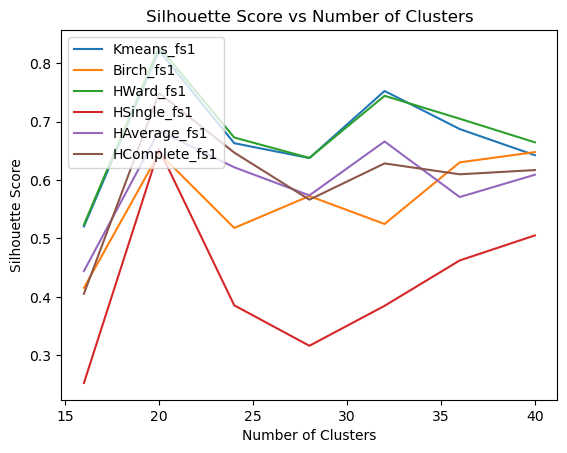

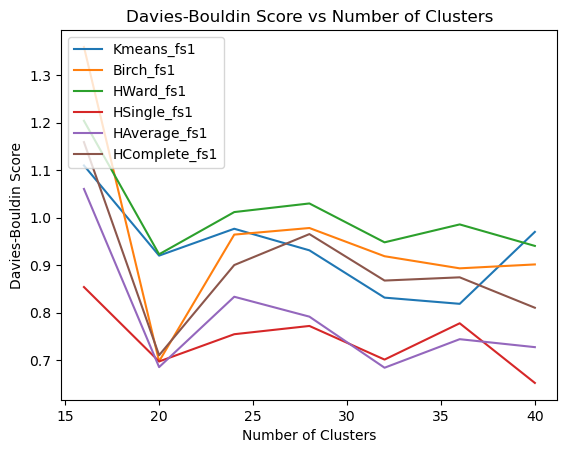

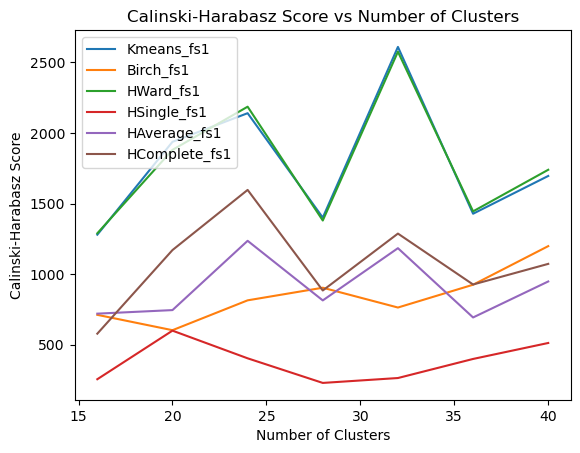

In [46]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[16, 20, 24, 28, 32, 36, 40])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette0.7058480141955747
Silhouette0.896825013499344
Silhouette0.7183037620862207
Silhouette0.8971347204912222
Silhouette0.8975676919216169
Silhouette0.8975676919216169
Davies-Bouldin1.081369682287355
Davies-Bouldin1.0979177661081347
Davies-Bouldin1.0860528025648528
Davies-Bouldin0.8984905192901629
Davies-Bouldin0.8596702205957817
Davies-Bouldin1.1189780630800974
Calinski-Harabasz39109.37717811041
Calinski-Harabasz7866.790614244342
Calinski-Harabasz36134.186712553645
Calinski-Harabasz8079.194977680835
Calinski-Harabasz8150.226070198869
Calinski-Harabasz8150.226070198869


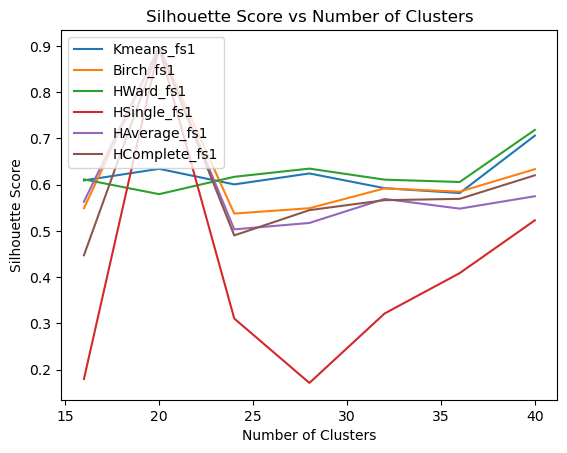

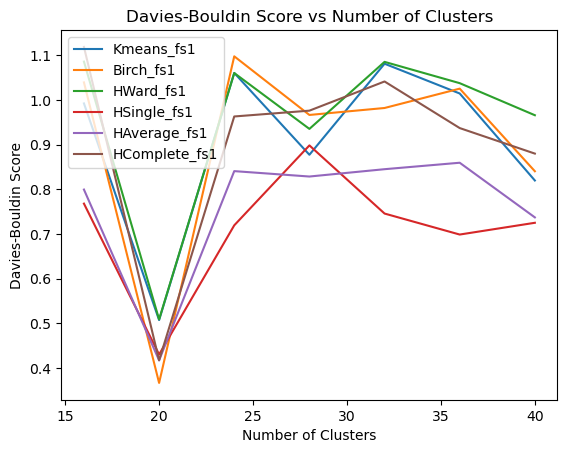

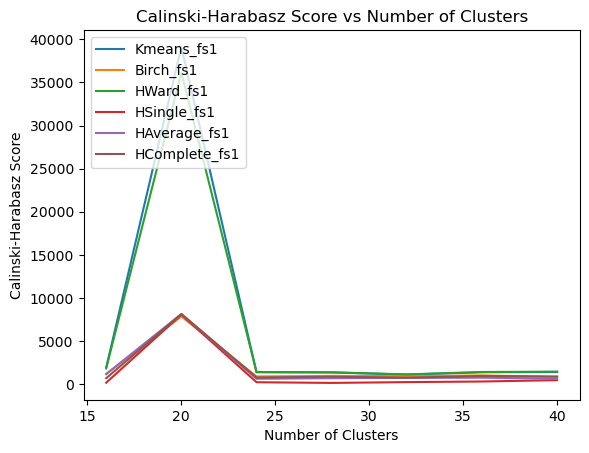

In [47]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[16, 20, 24, 28, 32, 36, 40])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette0.6775419967370365
Silhouette0.633870363283934
Silhouette0.6809341705470483
Silhouette0.508892557836402
Silhouette0.6601755711290564
Silhouette0.6419581859919985
Davies-Bouldin1.063571478601029
Davies-Bouldin1.130767333671016
Davies-Bouldin1.1221705181905386
Davies-Bouldin0.9479251704248142
Davies-Bouldin1.0296605244174937
Davies-Bouldin1.0764564278310982
Calinski-Harabasz1718.1849121659386
Calinski-Harabasz1080.2586259135228
Calinski-Harabasz1735.7945177560496
Calinski-Harabasz449.0465692240828
Calinski-Harabasz1060.7644363706486
Calinski-Harabasz1243.5567245142147


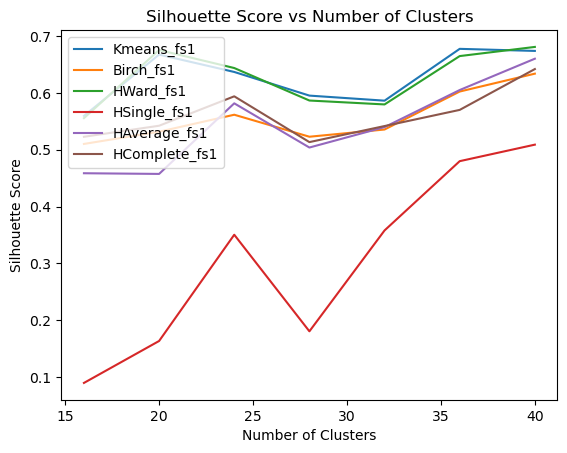

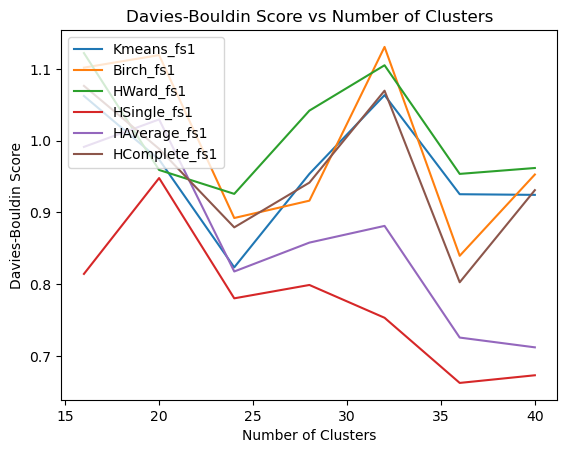

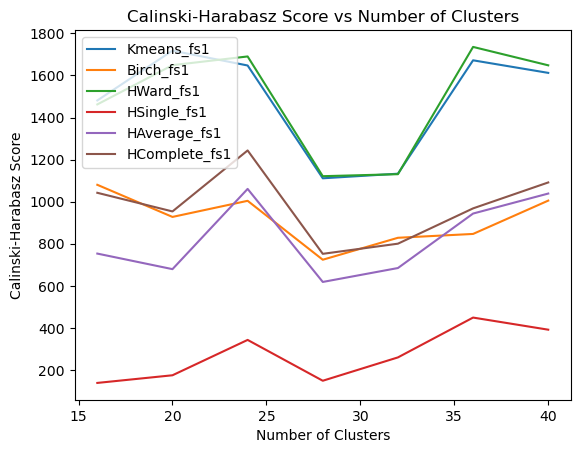

In [48]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[16, 20, 24, 28, 32, 36, 40])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette0.6907943505460432
Silhouette0.6547410453075072
Silhouette0.7038425144837422
Silhouette0.5579087933842509
Silhouette0.6465508597646983
Silhouette0.6245423920076331
Davies-Bouldin1.1693550899182503
Davies-Bouldin1.1606249688830814
Davies-Bouldin1.141757866157039
Davies-Bouldin0.8127661852761747
Davies-Bouldin1.0012747000190227
Davies-Bouldin1.1507636234109506
Calinski-Harabasz1705.3858623677731
Calinski-Harabasz1142.8187455629882
Calinski-Harabasz1758.4466760446364
Calinski-Harabasz466.99088854722936
Calinski-Harabasz991.1923170940621
Calinski-Harabasz1172.8302291276304


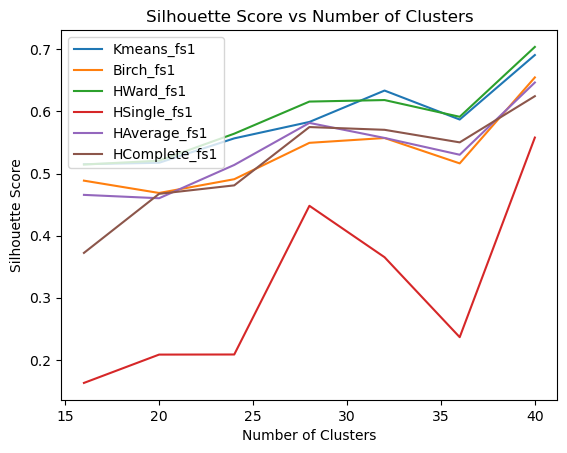

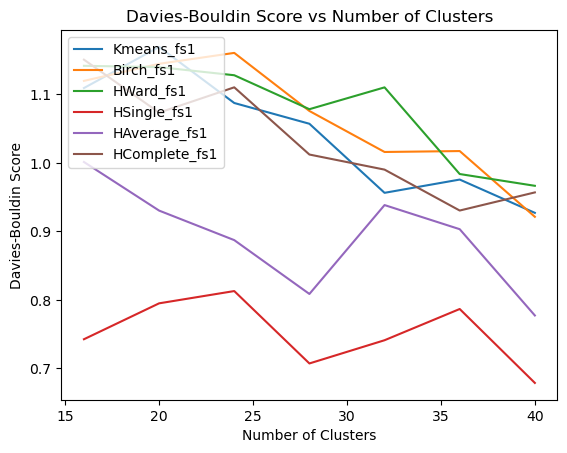

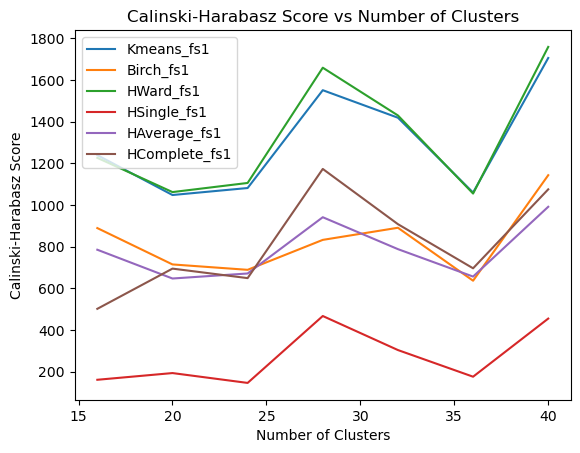

In [49]:
plot_metrics(files_count=[1], tries_count=1, sample_size=0.1, n_clusters=[16, 20, 24, 28, 32, 36, 40])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette0.7826286275833552
Silhouette0.9020358953843416
Silhouette0.7714069099871718
Silhouette0.9011689524629047
Silhouette0.9020358953843416
Silhouette0.9020358953843416
Silhouette0.7310724061931809
Silhouette0.5636956898656449
Silhouette0.7193453580935159
Silhouette0.3623605225603434
Silhouette0.5199232573082432
Silhouette0.5407623171946356
Davies-Bouldin1.213188374438349
Davies-Bouldin1.6151540365018682
Davies-Bouldin1.2813926744795618
Davies-Bouldin0.9317181199045417
Davies-Bouldin1.2551228479761616
Davies-Bouldin1.4294136236780965
Davies-Bouldin1.1407266879234723
Davies-Bouldin1.2839197882586308
Davies-Bouldin1.2597464651451817
Davies-Bouldin1.229225025220897
Davies-Bouldin1.1340393152869521
Davies-Bouldin1.4791518652820588
Calinski-Harabasz10405.530914873925
Calinski-Harabasz5879.507679351531
Calinski-Harabasz10323.396916996737
Calinski-Harabasz5738.589334605664
Calinski-Harabasz5879.507679351528
Calinski-Harabasz5879.50767935153
Calinski-Harabasz3542.781802292204
Calinski-Har

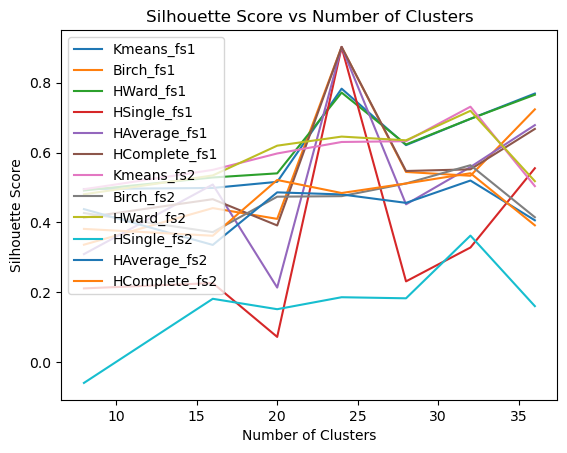

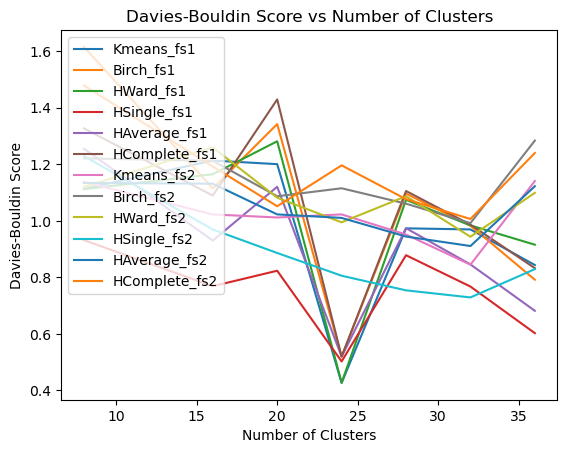

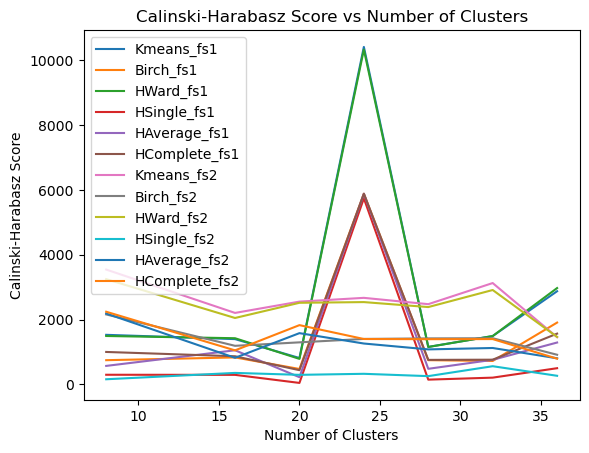

In [50]:
plot_metrics(files_count=[1, 2], tries_count=1, sample_size=0.1, n_clusters=[8, 16, 20, 24, 28, 32, 36])

In [ ]:
plot_metrics(files_count=[1, 2, 4], tries_count=1, sample_size=0.1, n_clusters=[8, 16, 20, 24, 28, 32, 36])

C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\aspet\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Silhouette0.9628840730616463
Silhouette0.9436556227910261
Silhouette0.9626736836069136
Silhouette0.9358597614661224
Silhouette0.944348790069064
Silhouette0.9426639164437866
Silhouette0.6885985648997448
Silhouette0.5291797813245821
Silhouette0.6934230315148404
Silhouette0.36906668289481287
Silhouette0.45793385286734783
Silhouette0.49783693032632137
Davies-Bouldin1.7190317517553435
Davies-Bouldin1.6016910465497167
Davies-Bouldin1.6305051363258747
Davies-Bouldin1.3283699265020823
Davies-Bouldin0.9574557499412573
Davies-Bouldin1.1276878792114882
Davies-Bouldin1.399382136019553
Davies-Bouldin1.5078860295686225
Davies-Bouldin1.3237720226456842
Davies-Bouldin1.0176821576719182
Davies-Bouldin1.2787850693728058
Davies-Bouldin1.541988568363956
Calinski-Harabasz22330.394772058142
Calinski-Harabasz9052.556797550214
Calinski-Harabasz22265.471296372736
Calinski-Harabasz6255.713141496236
Calinski-Harabasz9350.695475628929
Calinski-Harabasz8536.288210036668
Calinski-Harabasz2641.513677505305
Calinski-

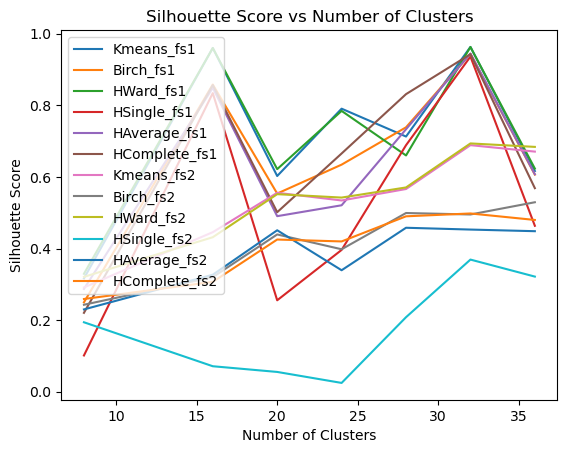

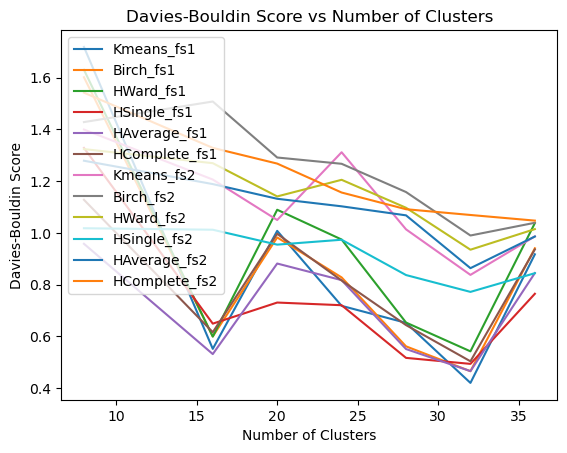

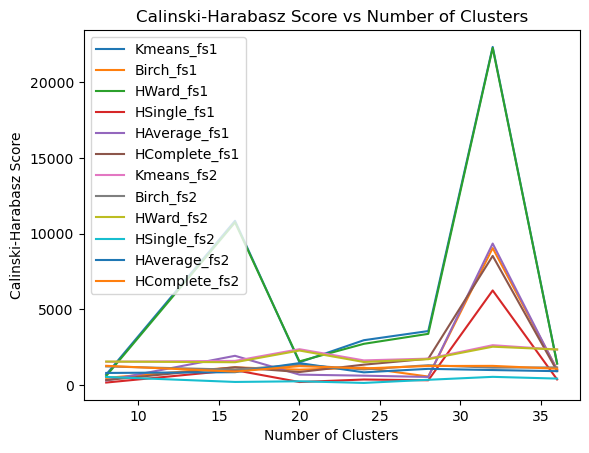

In [51]:
plot_metrics(files_count=[1, 2], tries_count=1, sample_size=0.1, n_clusters=[8, 16, 20, 24, 28, 32, 36])